In [12]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(1)
np.random.seed(1)
torch.set_printoptions(precision=3)

In [13]:
class MonotonicLinear(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size  = input_size
    self.output_size = output_size
    self.weights = torch.nn.Parameter(torch.rand((output_size, input_size), dtype=torch.float32))

  def forward(self, x):
    z = torch.mm(x, torch.exp(self.weights.t()))
    return z

In [14]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input1  = MonotonicLinear(2, 32)
    self.hidden1 = MonotonicLinear(32, 1)
    self.input2  = torch.nn.Linear(2, 32)
    self.hidden2 = torch.nn.Linear(32, 1)

  def forward(self, x_m, x_u):
    z1 = torch.tanh(self.input1(x_m))
    z1 = self.hidden1(z1)

    z2 = torch.tanh(self.input2(x_u))
    z2 = self.hidden2(z2)

    z = torch.add(z1, z2)
    return z

# Create network
device = torch.device("cpu")
net = Net().to(device)

In [15]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x_m_data, testset.x_u_data)
    
    # R^2
    SSR = torch.sum(torch.square(pred_Y - testset.y_data))
    SST = torch.sum(torch.square(pred_Y - torch.mean(testset.y_data)))
    r2 = 1 - SSR/SST

    # RMSE
    rmse = torch.sqrt(torch.mean(torch.square(pred_Y - testset.y_data)))
    return r2, rmse

In [16]:
# Create network
device = torch.device("cpu")
net = Net().to(device)

In [17]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file, start=None, end=None):
    df = pd.read_csv(src_file)
    Tca_k1   = np.array(df['ahu_supply_temp']).reshape(-1,1)[start+1: end+1]
    Tsa_k    = np.array(df['supply_discharge_temp']).reshape(-1,1)[start: end]
    Tsa_k1   = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+1: end+1]
    valve_k2 = np.array(df['htg_valve_position']).reshape(-1,1)[start+2: end+2]

    tmp_x_m = np.concatenate((Tca_k1, valve_k2), axis=1)
    tmp_x_u = np.concatenate((Tsa_k, Tsa_k1), axis=1)
    tmp_y   = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+2: end+2]

    self.x_m_data = torch.tensor(tmp_x_m, dtype=torch.float32)
    self.x_u_data = torch.tensor(tmp_x_u, dtype=torch.float32)
    self.y_data = torch.tensor(tmp_y, dtype=torch.float32)

  def __len__(self):
    return len(self.y_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    inp_m  = self.x_m_data[idx]
    inp_u  = self.x_u_data[idx]
    outp   = self.y_data[idx]
    sample = {'inp_m':inp_m,'inp_u':inp_u, 'outp':outp}
    return sample

# Create Dataset and DataLoader objects
src_file = 'C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv'
n_train  = 64
train_ds = Data(src_file, start=0,       end=n_train)
test_ds  = Data(src_file, start=n_train, end=1600)

In [18]:
# train model
max_epochs = 26966
loss_func  = torch.nn.MSELoss()
optimizer  = torch.optim.Adam(net.parameters(), lr=0.002)

R2_train   = np.array([])
RMSE_train = np.array([])
R2_test    = np.array([])
RMSE_test  = np.array([])

train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
for epoch in range(0, max_epochs+1):
    net.train()
    loss  = 0
    count = 0
    for (_, batch) in enumerate(train_ldr):
        X_m = batch['inp_m']
        X_u = batch['inp_u']
        Y   = batch['outp']

        optimizer.zero_grad()
        output = net(X_m, X_u)             # compute the output of the Network
        loss_val = loss_func(output, Y)    # loss function
        loss += loss_val.item()            # accumulate
        loss_val.backward()                # gradients
        optimizer.step()                   # update paramters
        count += 1

    net.eval()
    R2_train   = np.append(R2_train, eval(net, train_ds)[0].item())
    RMSE_train = np.append(RMSE_train, eval(net, train_ds)[1].item())
    R2_test    = np.append(R2_test, eval(net, test_ds)[0].item())
    RMSE_test  = np.append(RMSE_test, eval(net, test_ds)[1].item())


    if(epoch%1000==0):
        print("epoch = %5d \t loss = %11.3f \t RMSE = %8.3f \t R2 = %8.5f" % (epoch, loss/count, eval(net, test_ds)[1].item(), eval(net, test_ds)[0].item()))

epoch =     0 	 loss =     793.554 	 RMSE =   26.395 	 R2 = -0.27805
epoch =  1000 	 loss =     108.054 	 RMSE =    9.793 	 R2 = -9.77352
epoch =  2000 	 loss =      13.507 	 RMSE =    3.356 	 R2 =  0.87647
epoch =  3000 	 loss =       4.503 	 RMSE =    1.860 	 R2 =  0.97581
epoch =  4000 	 loss =       3.553 	 RMSE =    1.753 	 R2 =  0.97914
epoch =  5000 	 loss =       3.156 	 RMSE =    1.726 	 R2 =  0.97986
epoch =  6000 	 loss =       3.014 	 RMSE =    1.783 	 R2 =  0.97860
epoch =  7000 	 loss =       2.887 	 RMSE =    1.778 	 R2 =  0.97856
epoch =  8000 	 loss =       2.798 	 RMSE =    1.799 	 R2 =  0.97807
epoch =  9000 	 loss =       2.723 	 RMSE =    1.810 	 R2 =  0.97777
epoch = 10000 	 loss =       2.742 	 RMSE =    1.931 	 R2 =  0.97500
epoch = 11000 	 loss =       2.593 	 RMSE =    1.774 	 R2 =  0.97863
epoch = 12000 	 loss =       2.542 	 RMSE =    1.761 	 R2 =  0.97902
epoch = 13000 	 loss =       2.542 	 RMSE =    1.833 	 R2 =  0.97748
epoch = 14000 	 loss =       2.472

In [19]:
def plot(dataset, size):
  with torch.no_grad():
      pred_Y = net(dataset.x_m_data, dataset.x_u_data)

  plt.figure(figsize=size)
  plt.plot(dataset.y_data, 'b--', label=r'$T$ measured')
  plt.plot(pred_Y,         'r--', label=r'$T$ predicted')
  plt.ylabel(r'T($^oC$)')
  plt.legend()
  plt.show()

RMSE: 1.4592176675796509
R2:   0.9874923825263977


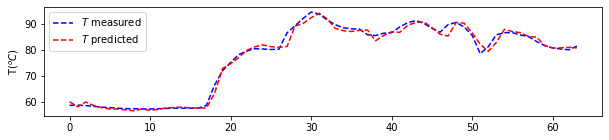

In [20]:
net.eval()
print("RMSE:", eval(net, train_ds)[1].item())
print("R2:  ", eval(net, train_ds)[0].item())
plot(train_ds, (10, 2))

RMSE: 1.5723092555999756
R2:   0.983738899230957


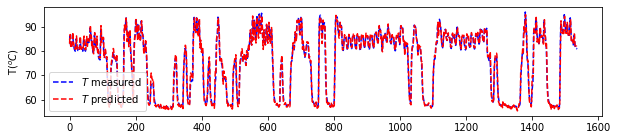

In [21]:
net.eval()
print("RMSE:", eval(net, test_ds)[1].item())
print("R2:  ",   eval(net, test_ds)[0].item())
plot(test_ds, (10, 2))

In [22]:
print(np.argmax(R2_test))
print(np.max(R2_test))

26966
0.983738899230957


In [23]:
PATH = 'C:/Users/tln229/Downloads/Python/Building/0. Saved models/Tsa.pt'
torch.save(net, PATH)